In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.config import threading
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization, Normalization, Dropout
from tensorflow.keras.layers import Reshape, Resizing, Softmax
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow_datasets as tfds
from random import randint

threading.set_inter_op_parallelism_threads(6)
threading.set_intra_op_parallelism_threads(6)

c:\Users\andre\.conda\envs\tf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_ds, info = tfds.load('citrus_leaves',
                                      split='train',
                                      with_info=True,
                                      shuffle_files=True,
                                      as_supervised=True,
                                      batch_size=64
                            )

In [3]:
DROPOUT_FACTOR = 0.3
REGULARIZATION = 1e-5

In [4]:
def create_model():
  model = Sequential([
      Input((None, None, 3)),
      Resizing(256, 256, 'bilinear', True),
      Normalization(),
      Conv2D(8, 3, padding='same',
              activation='relu',
              kernel_regularizer=L2(REGULARIZATION),
              kernel_initializer='random_normal'),
      BatchNormalization(),
      Conv2D(32, 3, (2, 2), padding='same',
              activation='relu',
              kernel_regularizer=L2(REGULARIZATION),
              kernel_initializer='random_normal'),
      BatchNormalization(),
      AvgPool2D((2, 2)),
      Conv2D(128, 3, (2, 2), padding='same',
              activation='relu',
              kernel_regularizer=L2(REGULARIZATION),
              kernel_initializer='random_normal'),
      BatchNormalization(),
      AvgPool2D((2, 2)),
      Conv2D(512, 3, (2, 2), padding='same',
              activation='relu',
              kernel_regularizer=L2(REGULARIZATION),
              kernel_initializer='random_normal'),
      BatchNormalization(),
      AvgPool2D((2, 2)),
      Conv2D(1024, 3, (2, 2), padding='same',
              activation='relu',
              kernel_regularizer=L2(REGULARIZATION),
              kernel_initializer='random_normal'),
      BatchNormalization(),
      AvgPool2D((2, 2)),
      Flatten(),
      Dense(192, activation='relu',
              kernel_regularizer=L2(REGULARIZATION),
              kernel_initializer='random_normal'),
      BatchNormalization(),
      Dense(96, activation='relu',
              kernel_regularizer=L2(REGULARIZATION),
              kernel_initializer='random_normal'),
      BatchNormalization(),
      Dense(32, activation='relu',
              kernel_regularizer=L2(REGULARIZATION),
              kernel_initializer='random_normal'),
      BatchNormalization(),
      Dense(8, activation='relu',
              kernel_regularizer=L2(REGULARIZATION),
              kernel_initializer='random_normal'),
      BatchNormalization(),
      Dense(4, activation='relu',
              kernel_regularizer=L2(REGULARIZATION),
              kernel_initializer='random_normal'),
      BatchNormalization(),
      Dense(4, activation='linear',
              kernel_regularizer=L2(REGULARIZATION),
              kernel_initializer='random_normal'),
      Dense(4, activation='softmax',
              kernel_initializer='random_normal')
  ])

  model.compile(optimizer=RMSprop(learning_rate=3e-3),
                loss=SparseCategoricalCrossentropy(from_logits=False),
                metrics=[SparseCategoricalAccuracy()])
  
  return model

In [5]:
#AndNet = create_model()

#AndNet.summary()

In [26]:
model_path = 'AndNet.h5'

cp_callback = ModelCheckpoint(filepath=model_path,
                            save_weights_only=False,
                            verbose=1)

if(os.path.exists(model_path)):
    AndNet = load_model(model_path)
    pass

'''
AndNet.fit(train_ds,
            epochs=3,
            callbacks=[cp_callback])
'''

Epoch 1/3
7/7 [==============================] - ETA: 0s - loss: 0.0180 - sparse_categorical_accuracy: 1.0000
Epoch 1: saving model to AndNet.h5
7/7 [==============================] - 6s 580ms/step - loss: 0.0180 - sparse_categorical_accuracy: 1.0000
Epoch 2/3
7/7 [==============================] - ETA: 0s - loss: 0.0154 - sparse_categorical_accuracy: 1.0000
Epoch 2: saving model to AndNet.h5
7/7 [==============================] - 4s 536ms/step - loss: 0.0154 - sparse_categorical_accuracy: 1.0000
Epoch 3/3
7/7 [==============================] - ETA: 0s - loss: 0.0130 - sparse_categorical_accuracy: 1.0000
Epoch 3: saving model to AndNet.h5
7/7 [==============================] - 4s 535ms/step - loss: 0.0130 - sparse_categorical_accuracy: 1.0000


Accuracy: 87.76470588235294 %


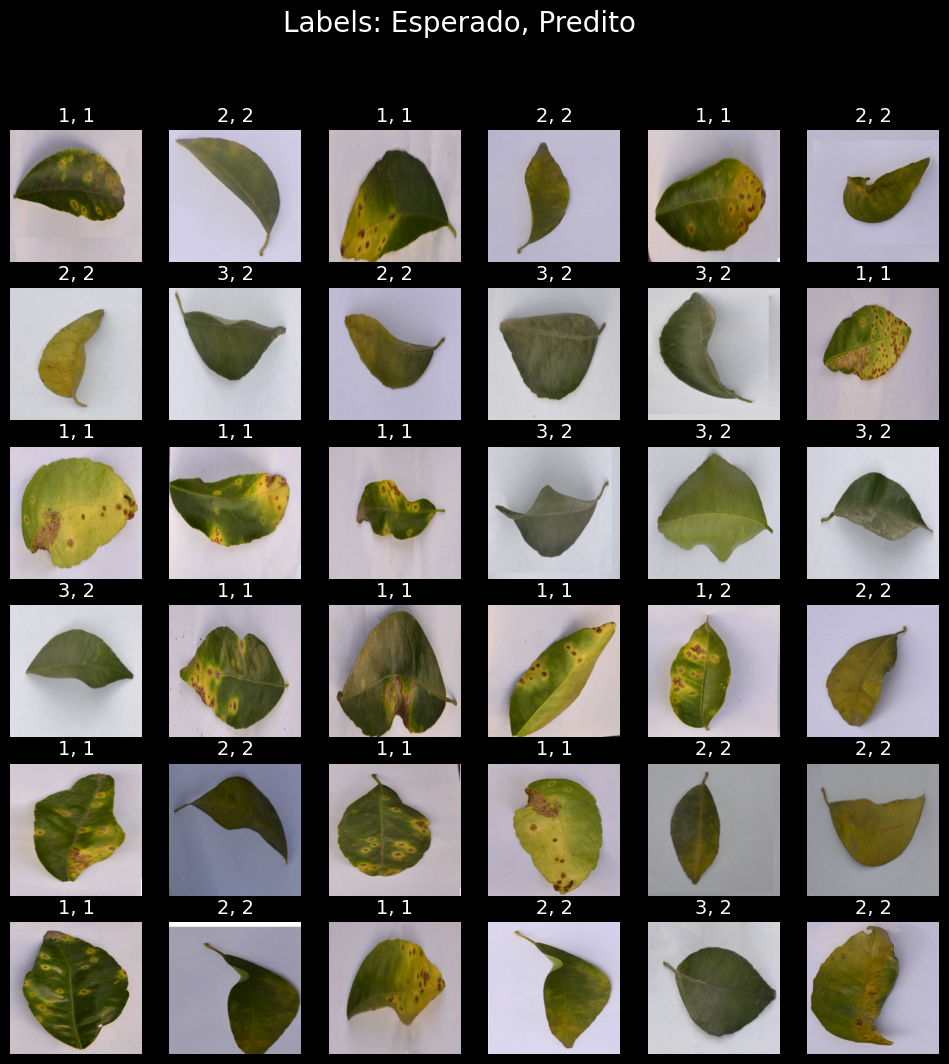

In [74]:
test_ds, test_info = tfds.load('citrus_leaves',
                                      split='train',
                                      with_info=True,
                                      shuffle_files=True)

test_df = tfds.as_dataframe(test_ds, test_info)

test_images = np.array(test_df['image'].tolist())

test_softmax = AndNet.predict(test_images, verbose=0)
test_outputs = np.array([np.argmax(outp) for outp in test_softmax])
test_comparison = np.array([np.array_equal((test_outputs[i]), test_df['label'].tolist()[i]) for i in range(test_outputs.shape[0])])
test_accuracy = np.sum(test_comparison)*100/test_comparison.shape[0]
print(f"Accuracy: {test_accuracy} %")

SUB_PLOT_X = 6
SUB_PLOT_Y = 6

index = [randint(0, test_df.shape[0] - 1) for i in range(SUB_PLOT_X * SUB_PLOT_Y)]

fig, axs = plt.subplots(SUB_PLOT_X, SUB_PLOT_Y, figsize=(2*SUB_PLOT_Y, 2*SUB_PLOT_X))
fig.suptitle('Labels: Esperado, Predito', fontsize=20, color="white")
fig.set_facecolor('black')
for i in range(SUB_PLOT_X):
    for j in range(SUB_PLOT_Y):
        test_predict = AndNet.predict(test_df['image'][index[i*SUB_PLOT_X + j]].reshape(1, 256, 256, 3), verbose=0)
        axs[i, j].imshow(test_df['image'][index[i*SUB_PLOT_X + j]])
        axs[i, j].axis('off')
        axs[i, j].set_title(f'{test_df["label"][index[i*SUB_PLOT_X + j]]}, {np.argmax(test_predict)}', fontsize=14, color="white")